In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import dill
import sys
sys.path.append('../spock/')
from modelfitting import ROC_curve
try:
    plt.style.use('paper')
except:
    pass
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, auc 
from sklearn import metrics

%matplotlib inline

In [2]:
df = pd.read_csv('../training_data/random/additional_featuresNorbits10000.0Nout80trio/trainingdata.csv', index_col=0)
df.head()

,EMfracstdnear,EPstdnear,AMDcritnear,AMDtriofracnear,EMcrossnear,MMRstrengthnear,jnear,knear,EMfracstdfar,EPstdfar,...,AMDtriofracfar,EMcrossfar,MMRstrengthfar,jfar,kfar,MEGNO,MEGNOstd,stableinshortintegration,betanear,betafar
0,0.017541,0.002926,1.528816e-06,0.179303,0.221502,0.104304,4.0,1.0,0.085902,0.011958,...,0.746206,0.300893,0.086203,3.0,1.0,1.898446,0.230729,1.0,5.899524,10.973806
1,0.077672,0.011380,2.887466e-08,18.103058,0.190647,0.038132,4.0,1.0,0.005893,0.000481,...,0.105373,0.403777,0.158567,5.0,2.0,14.355573,4.640704,1.0,5.822156,10.655311
2,0.034139,0.001508,1.618682e-06,0.775585,0.125660,0.294964,6.0,1.0,0.016446,0.008311,...,10.580081,0.720557,NaN,NaN,NaN,6.272737,1.391632,1.0,2.399923,17.493136
3,0.008563,0.002451,6.619971e-08,0.822370,0.216684,0.012940,4.0,1.0,0.003954,0.000146,...,0.366289,0.235460,0.013126,4.0,1.0,2.001120,0.221890,1.0,12.836670,13.275018
4,2.164908,0.005368,3.426953e-10,180.485419,0.024455,NaN,28.0,1.0,1.609929,0.016637,...,120.737483,0.034058,0.030520,41.0,2.0,NaN,NaN,1.0,2.030812,3.809463


In [3]:
dfres = pd.read_csv('resPratios.csv', index_col=0)
dfrand = pd.read_csv('randomPratios.csv', index_col=0)

# Models trained on resonant dataset

Test on full 25,000 random systems

N-body AUC = 0.9912 Thresh = 0.030 TPR = 0.998 FPR = 0.108 Thresh = 0.998 TPR = 0.974 FPR = 0.015
SPOCK AUC = 0.9745 Thresh = 0.385 TPR = 0.938 FPR = 0.100 Thresh = 0.630 TPR = 0.900 FPR = 0.071
MEGNO AUC = 0.9494 Thresh = 0.937 TPR = 0.868 FPR = 0.101 Thresh = 0.918 TPR = 0.902 FPR = 0.119
AMD AUC = 0.9020 Thresh = 0.943 TPR = 0.727 FPR = 0.100 Thresh = 0.883 TPR = 0.900 FPR = 0.313
Hill AUC = 0.8208 Thresh = 0.954 TPR = 0.386 FPR = 0.100 Thresh = 0.875 TPR = 0.900 FPR = 0.406


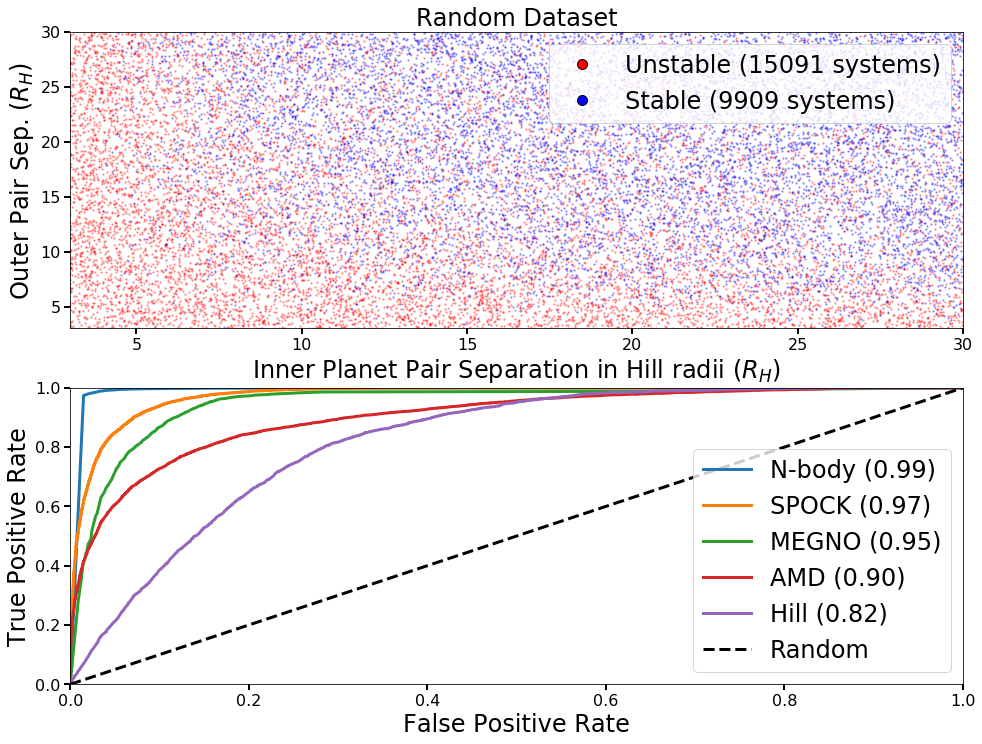

In [24]:
from xgboost.sklearn import XGBClassifier

fs = 24
FPRthresh=0.1
TPRthresh=0.9
models = {'N-body':'nbody', 'SPOCK':'spock', 'MEGNO':'megno', 'AMD':'AMD', 'Hill':'hill'}
featuresdic = {'N-body':['shadow_instability_time'], 'SPOCK':None, 'MEGNO':['MEGNO'], 'AMD':['AMDtriofracnear', 'AMDtriofracfar'], 'Hill':['betanear', 'betafar']}

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(2, 1, figure=fig)
gs.update(hspace=0.2)

stable = dfrand['instability_time'] > 9.99e8
ax1 = plt.subplot(gs[0])
ax1.set_rasterization_zorder(1)
ax1.scatter(dfrand['beta12'][~stable], dfrand['beta23'][~stable], c = 'r', s=2, alpha=0.3, zorder=0)
ax1.scatter(dfrand['beta12'][stable], dfrand['beta23'][stable], c = 'b', s=2, alpha=0.3, zorder=0)

ax1.set_xlim([3,30])
ax1.set_ylim([3,30])
ax1.set_xlabel(r'Inner Planet Pair Separation in Hill radii ($R_H$)', fontsize=fs)
ax1.set_ylabel(r'Outer Pair Sep. ($R_H$)', fontsize=fs)
ax1.locator_params(nbins=6)
ax1.set_title('Random Dataset')


Nstable = stable.sum()
Nunstable = (~stable).sum()
legend_elements = [Line2D([0], [0], marker='o', lw=0, c='k', markerfacecolor='r', label='Unstable ({0} systems)'.format(Nunstable), markersize=10),
                   Line2D([0], [0], marker='o', lw=0, c='k', label='Stable ({0} systems)'.format(Nstable), markerfacecolor='b', markersize=10)]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=fs)

testing_dataset = 'random'

ax = plt.subplot(gs[1])

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_ylabel('True Positive Rate', fontsize=fs)
ax.set_xlabel('False Positive Rate', fontsize=fs)


for name, filename in models.items():
    model = XGBClassifier()
    model.load_model('../spock/models/'+filename+'.json')
    if name == 'SPOCK':
        testingdatafolder = '../training_data/random/featuresNorbits10000.0Nout80trio/'  
    elif name == 'N-body':
        testingdatafolder = '../training_data/random/shadowtimes/'
    else:
        testingdatafolder = '../training_data/random/additional_featuresNorbits10000.0Nout80trio/'
    
    dataset = pd.read_csv(testingdatafolder+"trainingdata.csv", index_col = 0)
    labels = pd.read_csv(testingdatafolder+"labels.csv", index_col=0)
    y = labels['Stable']
    
    features = featuresdic[name]
    if features is None:
        features = dataset.columns.values
    
    X = dataset[features]
    preds = model.predict_proba(X)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    threshindex = np.where(fpr > FPRthresh)[0][0]
    tprthreshindex = np.where(tpr > TPRthresh)[0][0]
    print(name, "AUC = {0:.4f} Thresh = {1:.3f}".format(roc_auc, ROCthresholds[threshindex]),  "TPR = {0:.3f}".format(tpr[threshindex]), "FPR = {0:.3f}".format(fpr[threshindex]), 
         "Thresh = {0:.3f}".format(ROCthresholds[tprthreshindex]),  "TPR = {0:.3f}".format(tpr[tprthreshindex]), "FPR = {0:.3f}".format(fpr[tprthreshindex]))
    ax.plot(fpr, tpr, label='{0} ({1:.2f})'.format(name, roc_auc))

ax.plot(np.linspace(0,1), np.linspace(0,1), 'k--', label='Random')

ax.legend(fontsize=fs)
fig.savefig('randomperformance.pdf', bbox_inches='tight')